In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchvision
import torchvision.transforms.v2 as transforms
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics.functional import multiclass_accuracy
from torch.ao.quantization import QuantStub, DeQuantStub

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
class DatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        # print(x)
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [4]:
transform_train = transforms.Compose([
    transforms.ColorJitter(),
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=False, download=True, transform=transform_test)

trainset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=True, download=True)

# split the train set into train/validation
train_set_size = int(len(trainset) * 0.8)
valid_set_size = len(trainset) - train_set_size

seed = torch.Generator().manual_seed(42)
trainset, validset = torch.utils.data.random_split(trainset, [train_set_size, valid_set_size], generator=seed)

trainset = DatasetWrapper(trainset, transform_train)
validset = DatasetWrapper(validset, transform_test)

# Create train dataloader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=512, shuffle=True, num_workers=24)

# Create validation dataloader
validloader = torch.utils.data.DataLoader(
    validset, batch_size=512, shuffle=False, num_workers=24)

# Create test dataloader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=512, shuffle=False, num_workers=24)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


/home/semar/.local/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [5]:
class SeparableConv2d(nn.Module):
    '''Separable convolution'''
    def __init__(self, in_channels, out_channels, stride=1):
        super(SeparableConv2d, self).__init__()
        self.dw_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=False),
        )
        self.pw_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
        )

    def forward(self, x):
        x = self.dw_conv(x)
        x = self.pw_conv(x)
        return x

In [6]:
class MyMobileNet(pl.LightningModule):
    cfg = [
        (32, 64, 1), 
        (64, 128, 2), 
        (128, 128, 1), 
        (128, 256, 2),
        (256, 256, 1),
        (256, 512, 2),
        (512, 512, 1),
        (512, 512, 1),
        (512, 512, 1),
        (512, 512, 1),
        (512, 512, 1),
        (512, 1024, 2),
        (1024, 1024, 1),
    ]
    
    def __init__(self, num_classes=10, alpha: float = 1):
        super(MyMobileNet, self).__init__()
        conv_out = int(32 * alpha)
        self.conv = nn.Conv2d(3, conv_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(conv_out)
        self.relu = nn.ReLU(inplace=False)
        # self.accuracy = Accuracy("multiclass", num_classes=num_classes)
        # self.accuracy = MulticlassAccuracy()
        self.accuracy = multiclass_accuracy

        self.features = self.make_feature_extractor(alpha)
        self.linear = nn.Linear(1024, num_classes)

    def make_feature_extractor(self, alpha):
        layer_values = [(int(inp*alpha), int(out*alpha), chan) for inp, out, chan in self.cfg]
        layers = nn.Sequential(*[SeparableConv2d(*tup) for tup in layer_values])
        return layers

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.features(x)
        x = F.avg_pool2d(x, 2)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        return x
        
    def step(self, batch, batch_idx):
    # def training_step(self):
        x, y = batch
        logits = self.forward(x)
        loss = self.compute_loss(logits, y)
        acc = self.accuracy(logits, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
    # def training_step(self):
        loss, acc = self.step(batch, batch_idx)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
    # def training_step(self):
        loss, acc = self.step(batch, batch_idx)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss, acc = self.step(batch, batch_idx)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def configure_optimizers(self):
        self.lr = 0.02089
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.3, total_steps=MAX_EPOCHS * len(trainloader))
        return { "optimizer": optimizer, "lr_scheduler": scheduler }
        
    def compute_loss(self, logits, labels):
        return nn.functional.cross_entropy(logits, labels)

In [17]:
# from lightning.pytorch.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

# MAX_EPOCHS = 5 # leads to better than random guessing on quantized model with default_qconfig
MAX_EPOCHS = 50

model = MyMobileNet()

checkpoint_callback = ModelCheckpoint(
    # monitor='val_accuracy',
    dirpath='checkpoints/',
    filename='QUANT-{epoch:02d}-{val_accuracy:.2f}'
)
progress_callback = RichProgressBar(leave=True)

trainer = pl.Trainer(max_epochs=MAX_EPOCHS, callbacks=[checkpoint_callback, progress_callback])

# tune = Tuner(trainer)
# optimal_lr = tune.lr_find(model, train_dataloaders=trainloader, val_dataloaders=validloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=validloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ conv     │ Conv2d      │    864 │
│ 1 │ bn       │ BatchNorm2d │     64 │
│ 2 │ relu     │ ReLU        │      0 │
│ 3 │ features │ Sequential  │  3.2 M │
│ 4 │ linear   │ Linear      │ 10.2 K │
└───┴──────────┴─────────────┴────────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


In [19]:
trainer.test(model, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8281000256538391     │
│         test_loss         │    0.5298764705657959     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5298764705657959, 'test_accuracy': 0.8281000256538391}]

In [20]:
MODEL_WEIGHTS_PATH = './checkpoints/test.pth'

In [21]:
print('==> saving model')
state = {
    'net': model.state_dict(),
    'acc': '0.747299',
    'epoch': 50,
}

torch.save(state, MODEL_WEIGHTS_PATH)

==> saving model


In [22]:
# quantized_model.to("cuda")
saved = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(saved['state_dict'])
model.load_state_dict(saved['net'])
trainer.test(model, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8280999660491943     │
│         test_loss         │    0.5298764705657959     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5298764705657959, 'test_accuracy': 0.8280999660491943}]

# Post Training Quantization!

In [27]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')


class QuantizedMobileNet(MyMobileNet):
    def __init__(self, num_classes=10, alpha: float = 1):
        super(QuantizedMobileNet, self).__init__(num_classes, alpha)
        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.relu(self.bn(self.conv(x)))
        x = self.features(x)
        x = F.avg_pool2d(x, 2)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        x = self.dequant(x)
        return x
        
    def training_step(self, batch, batch_idx):
    # def training_step(self):
        loss, acc = self.step(batch, batch_idx)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    # Fuse Conv+BN and Conv+BN+Relu modules prior to quantization
    # This operation does not change the numerics
    def fuse_model(self, is_qat=False):
        fuse_modules = torch.ao.quantization.fuse_modules_qat if is_qat else torch.ao.quantization.fuse_modules
        fuse_modules(self, ["conv", "bn", 'relu'], inplace=True)
        for m in self.modules():
            if type(m) == SeparableConv2d:
                fuse_modules(m.dw_conv, ['0', '1', '2'], inplace=True)
                fuse_modules(m.pw_conv, ['0', '1', '2'], inplace=True)

In [28]:
# Baseline
model = QuantizedMobileNet()
saved = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(saved['state_dict'])
model.load_state_dict(saved['net'])
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)

trainer = pl.Trainer(callbacks=[progress_callback])

trainer.test(model, testloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Size (MB): 13.002226


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8281000256538391     │
│         test_loss         │    0.5298764705657959     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5298764705657959, 'test_accuracy': 0.8281000256538391}]

In [29]:
# Fused model
model = QuantizedMobileNet().to("cpu")
saved = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(saved['state_dict'])
model.load_state_dict(saved['net'])
model.eval()
model.fuse_model()
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)

trainer = pl.Trainer(accelerator = "cpu", callbacks=[progress_callback])

trainer.test(model, testloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Size (MB): 12.846458


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8281000256538391     │
│         test_loss         │    0.5299545526504517     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5299545526504517, 'test_accuracy': 0.8281000256538391}]

# Quantization Aware Training (QAT)

In [ ]:
backend = "fbgemm"
model = QuantizedMobileNet()
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
model.load_state_dict(checkpoint['net'])
model.eval()
model.fuse_model()
# model.qconfig = torch.ao.quantization.default_qconfig # This leads to bad results.

model.qconfig = torch.quantization.get_default_qconfig(backend)

print(model.qconfig)
torch.ao.quantization.prepare(model, inplace=True)

# Calibrate first
print('Post Training Quantization Prepare: Inserting Observers')
print('\n SeparableConv Block:After observer insertion \n\n', model.features[1].dw_conv)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)

torch.ao.quantization.convert(model, inplace=True)

print('Post Training Quantization: Convert done')
print('\n SeparableConv Block: After fusion and quantization, note fused modules: \n\n', model.features[1].dw_conv)
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)
trainer.test(model, testloader)

In [89]:
model.eval()
progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)
trainer.test(model, testloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8302000164985657     │
│         val_loss          │    0.5223873257637024     │
└───────────────────────────┴───────────────────────────┘

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8248000144958496     │
│         test_loss         │    0.5349059104919434     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5349059104919434, 'test_accuracy': 0.8248000144958496}]

In [91]:
# from torch.quantization import quantize_fx
import torch.quantization._numeric_suite as ns

float_model = QuantizedMobileNet()
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
float_model.load_state_dict(checkpoint['net'])

wt_compare_dict = ns.compare_weights(float_model.state_dict(), model.state_dict())

print('keys of wt_compare_dict:')
print(wt_compare_dict.keys())

print("\nkeys of wt_compare_dict entry for conv1's weight:")
print(wt_compare_dict['conv.weight'].keys())
print(wt_compare_dict['conv.weight']['float'].shape)
print(wt_compare_dict['conv.weight']['quantized'].shape)

keys of wt_compare_dict:
dict_keys(['conv.weight', 'features.0.dw_conv.0.weight', 'features.0.pw_conv.0.weight', 'features.1.dw_conv.0.weight', 'features.1.pw_conv.0.weight', 'features.2.dw_conv.0.weight', 'features.2.pw_conv.0.weight', 'features.3.dw_conv.0.weight', 'features.3.pw_conv.0.weight', 'features.4.dw_conv.0.weight', 'features.4.pw_conv.0.weight', 'features.5.dw_conv.0.weight', 'features.5.pw_conv.0.weight', 'features.6.dw_conv.0.weight', 'features.6.pw_conv.0.weight', 'features.7.dw_conv.0.weight', 'features.7.pw_conv.0.weight', 'features.8.dw_conv.0.weight', 'features.8.pw_conv.0.weight', 'features.9.dw_conv.0.weight', 'features.9.pw_conv.0.weight', 'features.10.dw_conv.0.weight', 'features.10.pw_conv.0.weight', 'features.11.dw_conv.0.weight', 'features.11.pw_conv.0.weight', 'features.12.dw_conv.0.weight', 'features.12.pw_conv.0.weight', 'linear._packed_params._packed_params'])

keys of wt_compare_dict entry for conv1's weight:
dict_keys(['float', 'quantized'])
torch.Size(

In [92]:
def compute_error(x, y):
    Ps = torch.norm(x)
    Pn = torch.norm(x-y)
    return 20*torch.log10(Ps/Pn)

for key in wt_compare_dict:
    print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized'].dequantize()))

conv.weight tensor(3.2938)
features.0.dw_conv.0.weight tensor(0.6491)
features.0.pw_conv.0.weight tensor(6.9510)
features.1.dw_conv.0.weight tensor(4.5638)
features.1.pw_conv.0.weight tensor(3.5305)
features.2.dw_conv.0.weight tensor(-11.2404)
features.2.pw_conv.0.weight tensor(2.6691)
features.3.dw_conv.0.weight tensor(-19.9699)
features.3.pw_conv.0.weight tensor(1.9584)
features.4.dw_conv.0.weight tensor(-21.3644)
features.4.pw_conv.0.weight tensor(1.5898)
features.5.dw_conv.0.weight tensor(-28.6501)
features.5.pw_conv.0.weight tensor(1.3961)
features.6.dw_conv.0.weight tensor(-31.2184)
features.6.pw_conv.0.weight tensor(1.0854)
features.7.dw_conv.0.weight tensor(-32.9581)
features.7.pw_conv.0.weight tensor(1.1860)
features.8.dw_conv.0.weight tensor(-33.9495)
features.8.pw_conv.0.weight tensor(1.2124)
features.9.dw_conv.0.weight tensor(-30.8967)
features.9.pw_conv.0.weight tensor(0.9307)
features.10.dw_conv.0.weight tensor(-33.6013)
features.10.pw_conv.0.weight tensor(0.8755)
feature

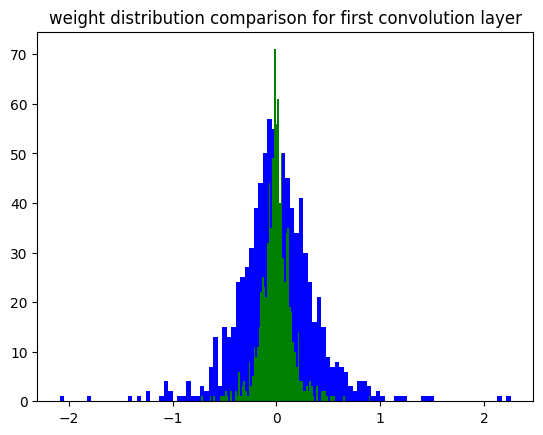

In [101]:
import matplotlib.pyplot as plt

f = wt_compare_dict['conv.weight']['float'].flatten()
plt.hist(f, bins = 100, color='blue')
plt.title("weight distribution comparison for first convolution layer")
# plt.show()

q = wt_compare_dict['conv.weight']['quantized'].dequantize().flatten()
plt.hist(q, bins = 100, color='green')
# plt.title("Quantized model weights of conv")
plt.show()

In [113]:
int8_np_ndarray = torch.int_repr(model.conv.weight()).numpy()